# Generate DTLZ2 PaletteViz 
## Code to generate 5D DTLZ2 PaletteViz plots for EMO-2021

This notebook generates different plots for 5D DTLZ2 for EMO-2021 paper.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})
np.random.seed(123456)

### Function to generate $\mathbf{R}$

In [2]:
import numpy as np
sys.path.append('../../')
from vis.generators import dtlz2
from vis.generators import c2dtlz2
from vis.generators import c0dtlz2

def generate_r(F, frontname, verbose=False):
    n = {'dtlz2': F.shape[0], 'c2dtlz2': 210000, 'c0dtlz2': 5000}
    
    LB, UB = np.mean(np.min(F, axis=0)), np.mean(np.max(F, axis=0))
    r = UB - LB
    if frontname == 'dtlz2':
        R, _ = dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c2dtlz2':
        R, _, _ = c2dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c0dtlz2':
        R, _, _ = c0dtlz2.surface(r=r, n=n[frontname], m=F.shape[1])
    else:
        raise ValueError("PF generation function for {:s} is not supported.".format(frontname))

    # check
    if verbose:
        print("F.shape =", F.shape)
        print("R.shape =", R.shape)
    
    return R

### An L2-norm based $\mathcal{d}_{\mathbf{F}}(\cdot)$ approximation function

In [3]:
import os
import numpy as np
sys.path.append('../../')
from vis.tda import simple_shape
from vis.utils import io

def approximate_depth_l2norm(F, frontname, save_ref_depth=False, verbose=False):
    # Generate a random data points that are on the same surface as F.
    # These points are R
    R = generate_r(F, frontname, verbose=verbose)
    
    # Now find depth contours from R
    if verbose:
        print("Computing depth contours of", pf)
    Dr = simple_shape.depth_contours(R, verbose=verbose)

    # Save in a temp file
    if save_ref_depth:
        drfname = frontname + "-r-depth-cont-cvhull.csv"
        drfpath = os.path.join("/tmp", drfname)
        io.savetxt(drfpath, Dr, fmt='{:d}', delimiter=',')
    
    # Find depth contour of F from that of R
    Dr_ = Dr[::-1]
    Id = np.arange(0,F.shape[0]).astype(int)
    Df = []
    while Id.shape[0] > 0:
        # for each layer l in d_R
        for l in Dr_:
            s = []
            # for each index i in l
            for i in l.astype(int):
                # find the point j in F that is closest to R[i]
                if Id.shape[0] > 0:
                    j = np.argmin(np.linalg.norm(F[Id]-R[i], axis=1))
                    s.append(Id[j])
                    Id = np.delete(Id, j)
                else:
                    break
            if len(s) > 0:
                Df.append(np.array(s).astype(int))
    Df = np.array(Df, dtype=object)
    Df = Df[::-1]
    
    # print and check counts
    if verbose:
        print("Df.shape[0] =", Df.shape[0])
        s = 0
        for i,l in enumerate(Df):
            print("Df[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

        print("Dr.shape[0] =", Dr.shape[0])
        s = 0
        for i,l in enumerate(Dr):
            print("Dr[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

    return R,Dr,Df

### Find depth-contours for the failed case

F.shape = (999, 5)
R.shape = (999, 5)
Computing depth contours of dtlz2-nbi
Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Computing depth contour 3 ...
Computing depth contour 4 ...
Computing depth contour 5 ...
Computing depth contour 6 ...
Computing depth contour 7 ...
Df.shape[0] = 9
Df[0].shape[0] = 224
Df[1].shape[0] = 209
Df[2].shape[0] = 169
Df[3].shape[0] = 145
Df[4].shape[0] = 99
Df[5].shape[0] = 69
Df[6].shape[0] = 59
Df[7].shape[0] = 21
Df[8].shape[0] = 4
total = 999
Dr.shape[0] = 9
Dr[0].shape[0] = 224
Dr[1].shape[0] = 209
Dr[2].shape[0] = 169
Dr[3].shape[0] = 145
Dr[4].shape[0] = 99
Dr[5].shape[0] = 69
Dr[6].shape[0] = 59
Dr[7].shape[0] = 21
Dr[8].shape[0] = 4
total = 999


<IPython.core.display.Javascript object>


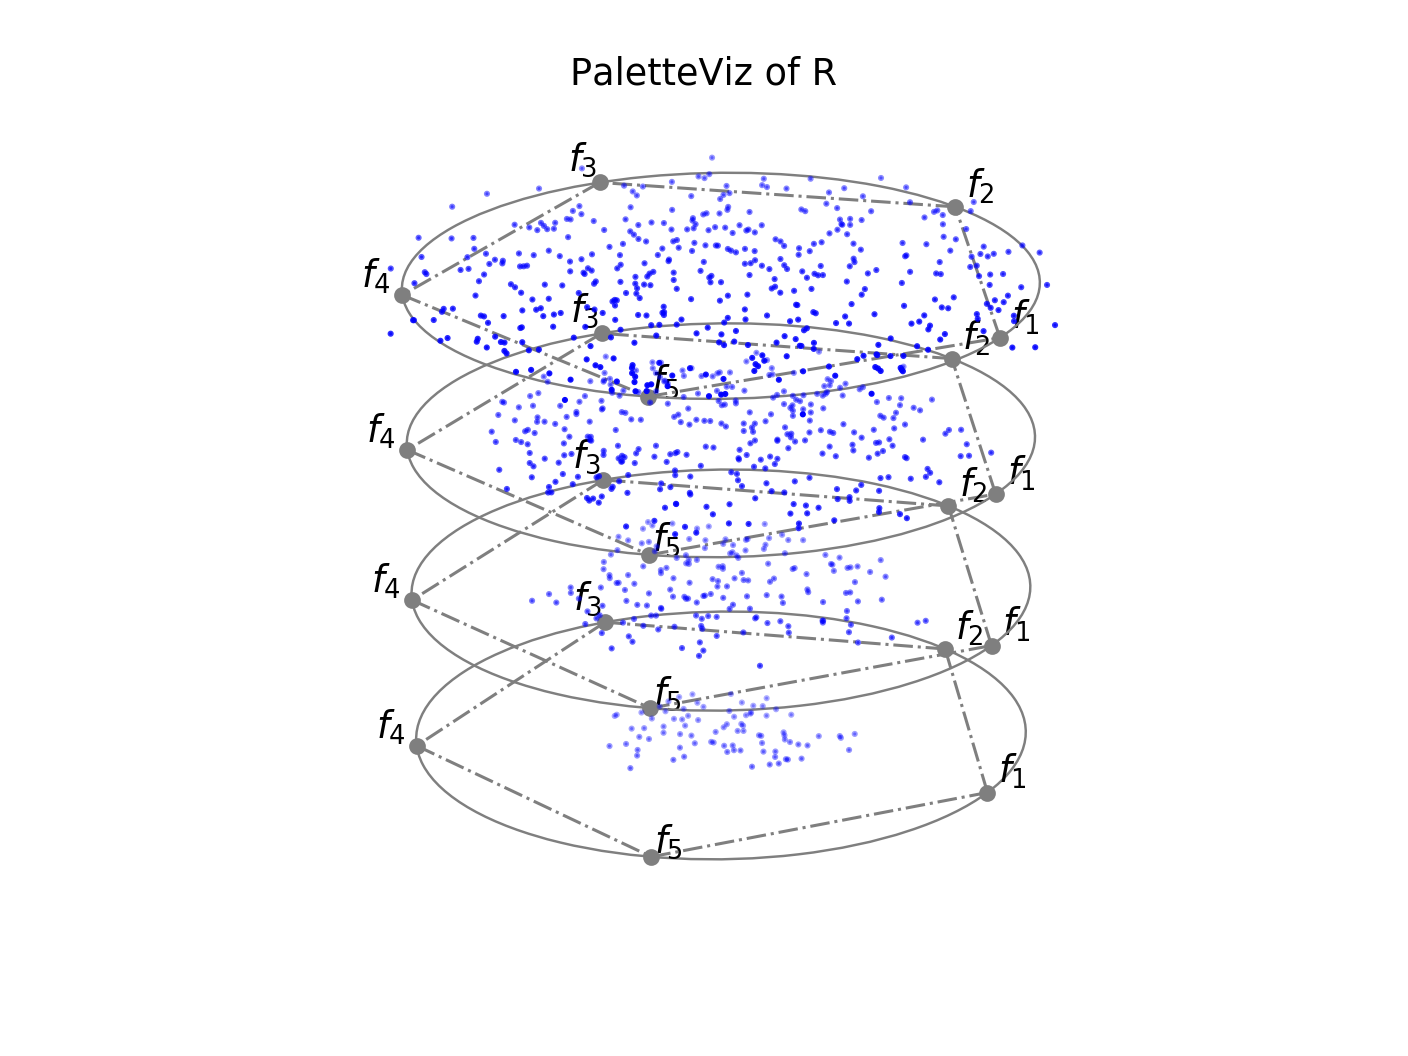

Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


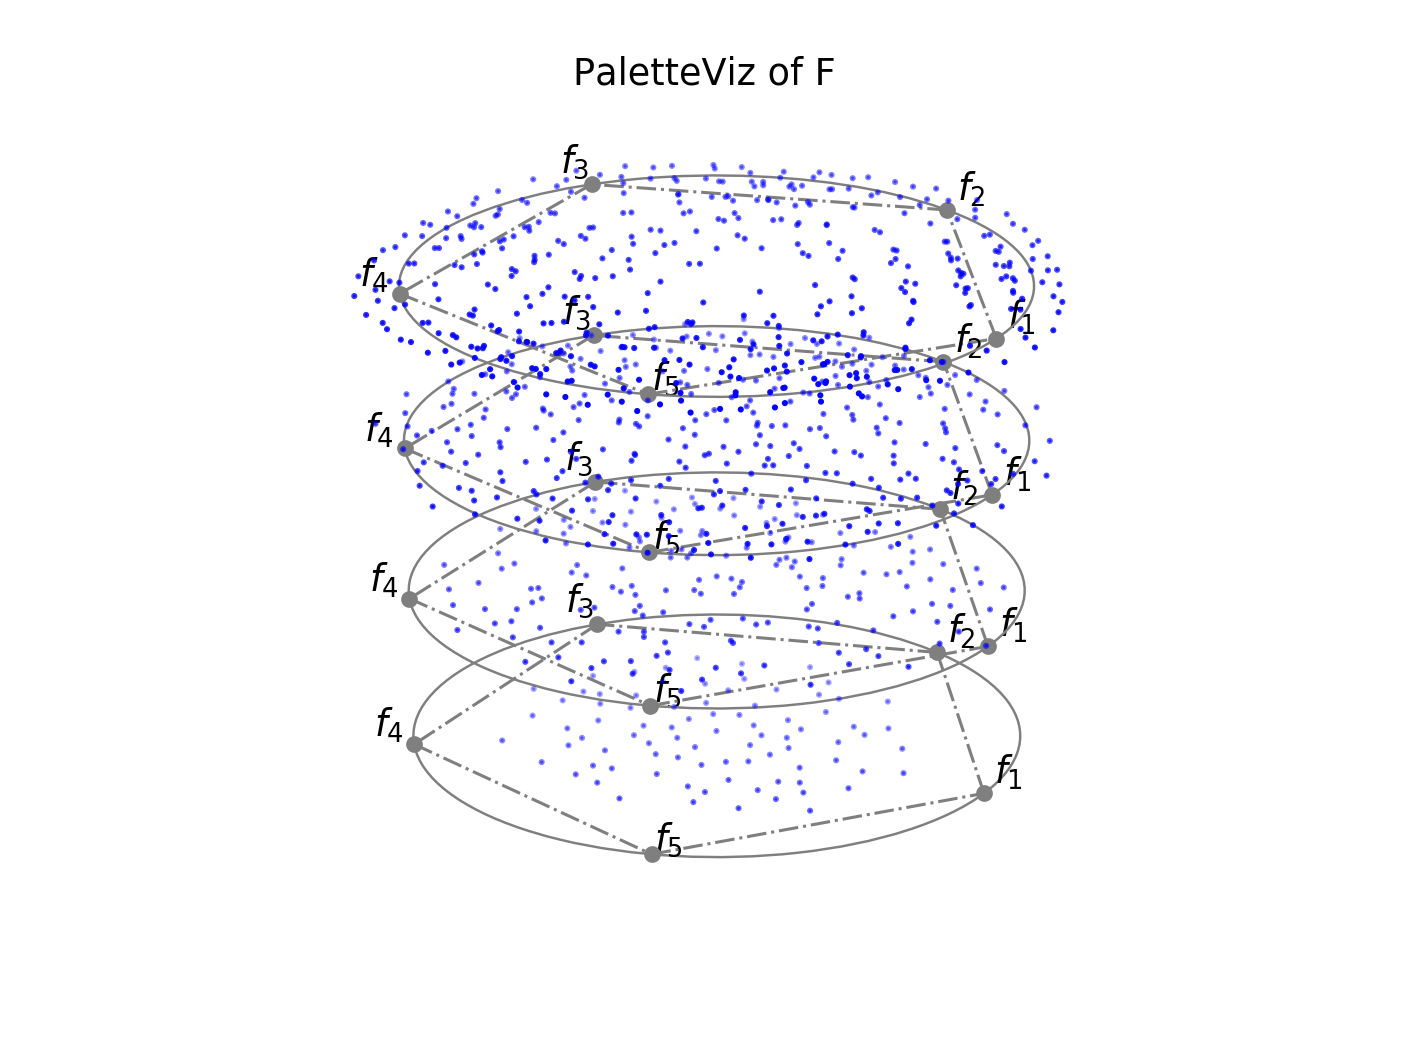

Plotting palette-star-viz.
Using depth contours ndarray.


In [4]:
sys.path.append('../../')
from vis.utils import io
from vis.plotting import paletteviz


# Data where the depth contours were not 
# possible to compute, these are F's.
pf, dim = 'dtlz2-nbi', '5d'

fpath = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fpath):
    path, _ = os.path.split(fpath)
    dirs = path.split('/')
    frontname = dirs[-2].split('-')[0]

    F = np.loadtxt(fpath, delimiter=',')

    # Approximate depth contours of F from R
    R,Dr,Df = approximate_depth_l2norm(F, frontname, verbose=True, save_ref_depth=True)

    # plot and verify
    paletteviz.plot(R, ax=Axes3D(plt.figure()), depth_contours=Dr, mode='star', \
                    n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of R")
    plt.show()

    # plot and verify
    paletteviz.plot(F, ax=Axes3D(plt.figure()), depth_contours=Df, mode='star', \
                    n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of F")
    plt.show()

    # save the layers
    io.savetxt(os.path.join(path, "depth-cont-cvhull.csv"), Df, fmt='{:d}', delimiter=',')

### Compute trade-offs

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


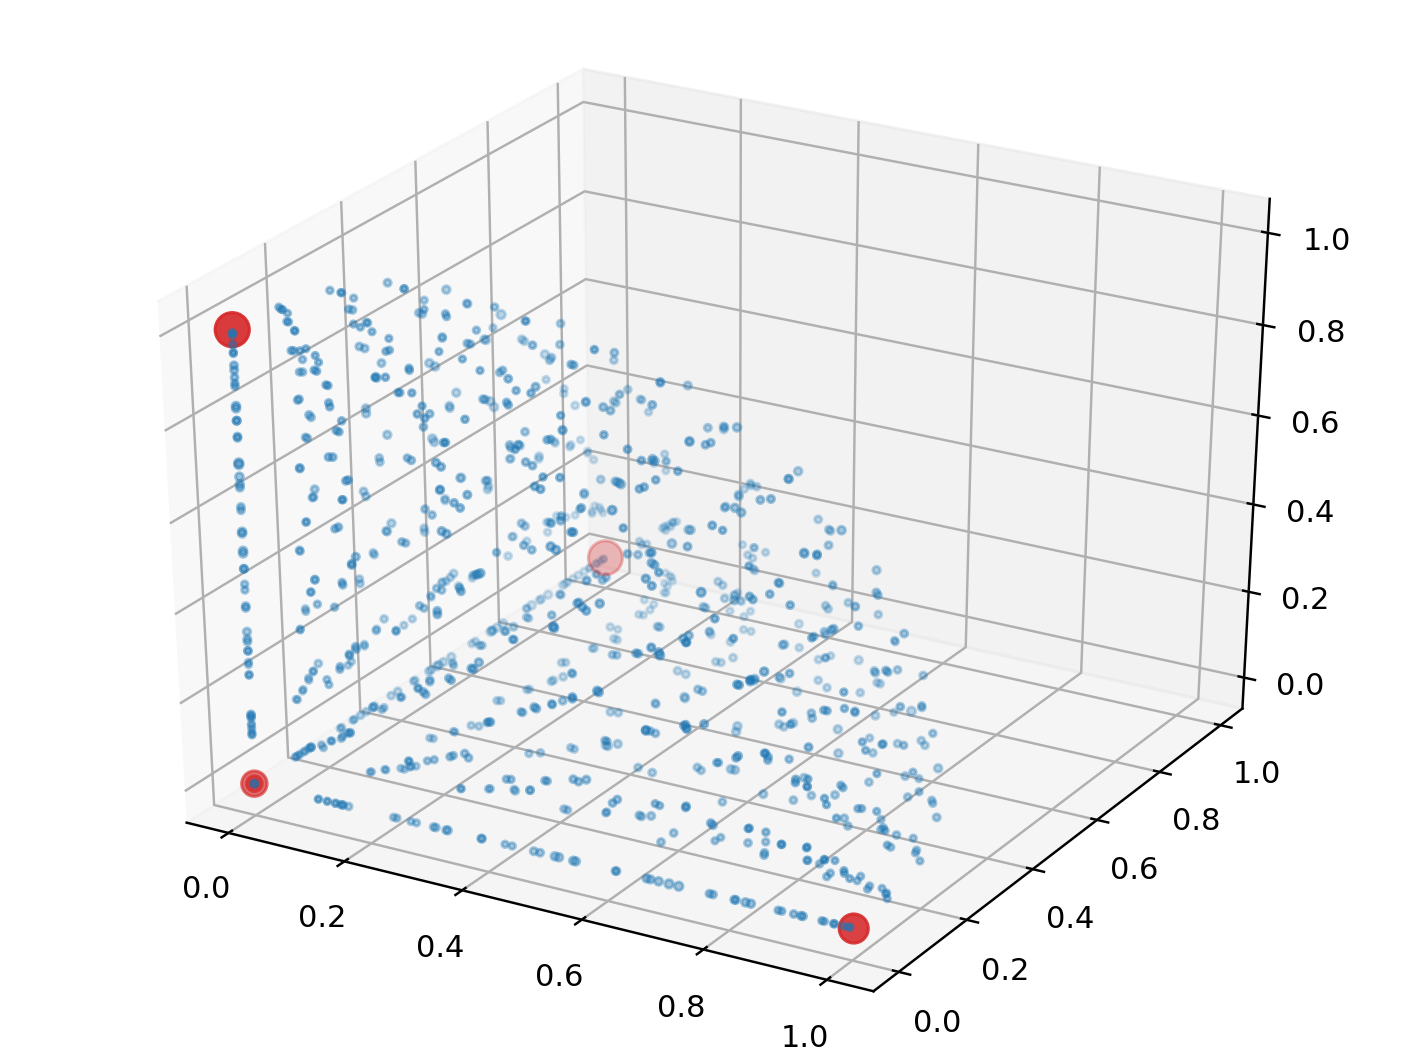

In [5]:
%matplotlib notebook

sys.path.append('../../')
from vis.utils import dm
from vis.plotting.utils import resize_by_tradeoff, default_color, \
                                color_by_cv, enhance_color

eps = dm.epsilons

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    Mu,Ik = dm.tradeoff(F, epsilon=eps[dim], penalize_extremes=False)
    mupathf = os.path.join(path, "mu.csv")
    np.savetxt(mupathf, Mu, delimiter=',', fmt="%1.4e")
    muidxpathf = os.path.join(path, "muid.csv")
    np.savetxt(muidxpathf, Ik, delimiter=',', fmt="%d")

    # default color array
    C = default_color(F.shape[0], alpha=0.5)

    # change the size w.r.t. Mu, the values are 
    # too big for smaller size plots, so we make 
    # them half.
    S = resize_by_tradeoff(Mu, k=Ik)

    # load CV if exists, use it for coloring
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf, delimiter=',')
        C = color_by_cv(CV)

    # enhance the knees with red
    C = enhance_color(C, k=Ik)

    # plot
    ax = Axes3D(plt.figure())
    ax.scatter(F[:,0], F[:,1], F[:,2], c=C, s=S)
    
    plt.show()
else:
    print("Error: {:s} not found.".format(fullpathf))

### Get appropriate color codings and other markings

In [6]:
sys.path.append('../../')
from vis.plotting.utils import resize_by_tradeoff, color_by_dist, color_by_cv, enhance_color

def load_props(path):
    r"""
    Load CV, Mu, Ik and S from path.
    """
    CV = None
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf)

    # load the Mu values
    Mu = None
    mupathf = os.path.join(path, "mu.csv")
    if os.path.exists(mupathf):
        Mu = np.loadtxt(mupathf)

    # load the knee indices
    Ik = None
    kpathf = os.path.join(path, "muid.csv")
    if os.path.exists(kpathf):
        Ik = np.loadtxt(kpathf, dtype = int)
        
    return CV, Mu, Ik

def decide_size_color(CV, Mu, Ik):
    r"""
    Decide point-size and color from `CV`, `Mu` and `Ik`
    """
    # decide point-size
    S = 1
    if Mu is not None and Ik is not None:
        S = resize_by_tradeoff(Mu, k=Ik)

    # decide colors
    # C = default_color(F.shape[0], alpha=0.5)
    M = np.mean(F, axis=0)
    C, _ = color_by_dist(F, M)
    
    # if CV is available, use CV to color
    if CV is not None:
        C = color_by_cv(CV)

    # enhance knee points
    if Ik is not None:
        C = enhance_color(C, Ik)
    return S, C

### Now do a scatter plot with appropriate colorcodings and markings

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


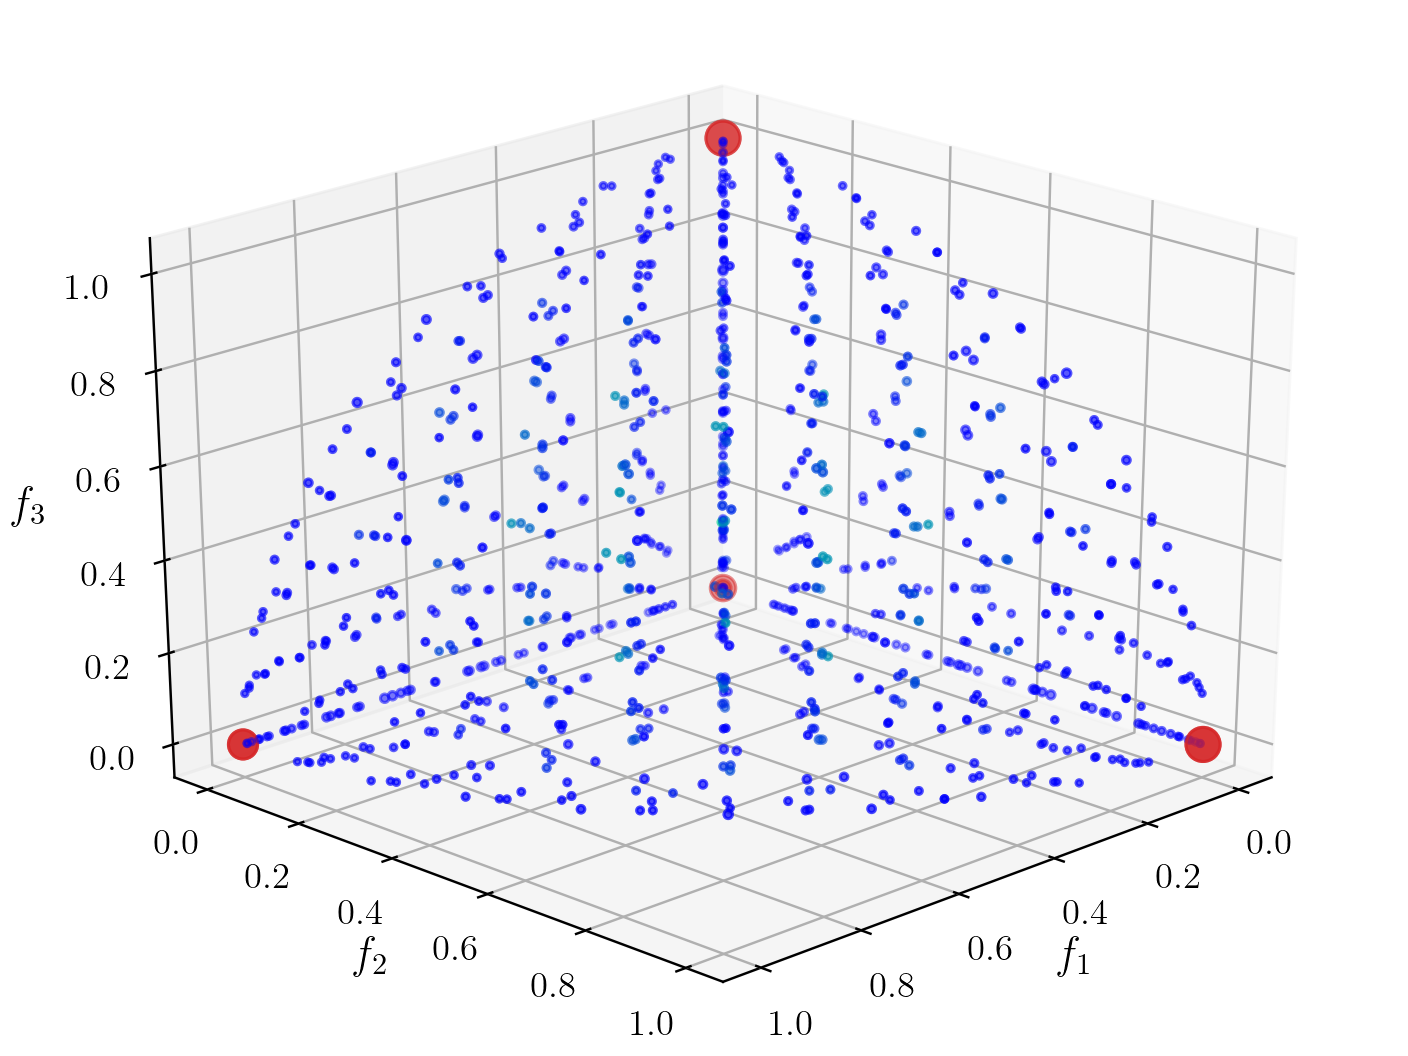

In [7]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)

    pdffigpath = os.path.join(path, "scatter3d.pdf")
    svgfigpath = os.path.join(path, "scatter3d.svg")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        scatter.plot(F, ax=Axes3D(plt.figure()), s=S, c=C, euler=(45,25))#camera_angles[pf][dim])
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.savefig(svgfigpath, bbox_inches='tight', pad_inches=0, dpi=150, format='svg')
        plt.show()

### Do paletteviz original

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


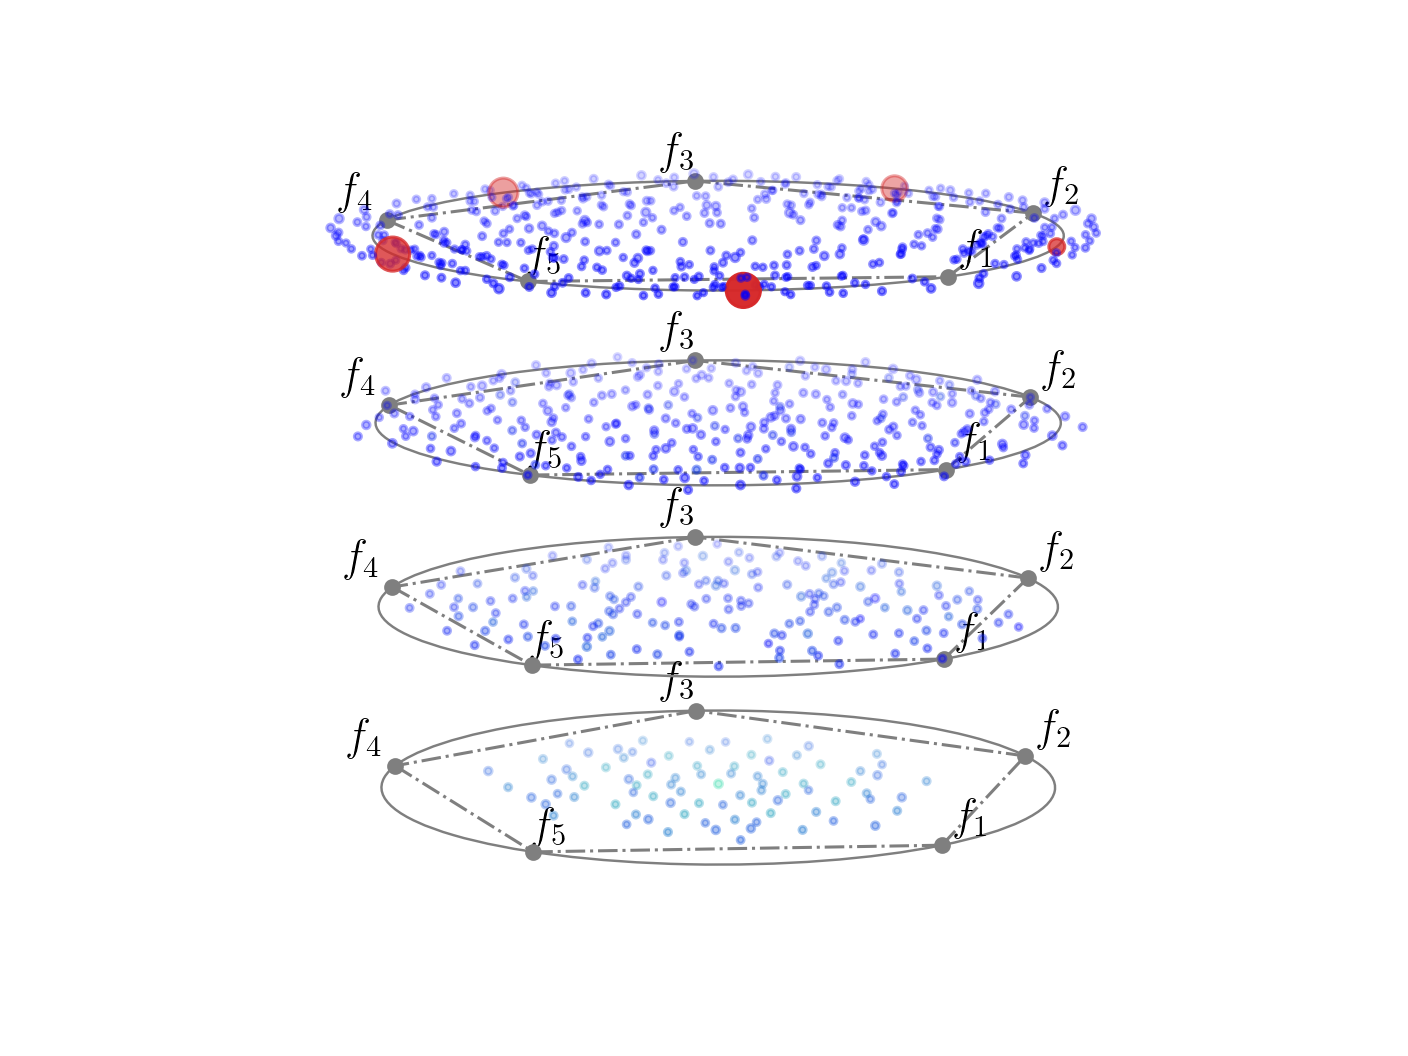

Plotting palette-star-viz.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.


In [8]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)

    pdffigpath = os.path.join(path, "palette-starviz.pdf")
    svgfigpath = os.path.join(path, "palette-starviz.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        paletteviz.plot(F, ax=Axes3D(plt.figure()), depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, verbose=True, euler=(-40,15)) #camera_angles_star[pf][dim])
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        plt.savefig(svgfigpath, bbox_inches='tight', dpi=150, pad_inches=0, format='svg')
        
        # show
        plt.show()

### Fig1: Plot 1000 points using PaletteViz in four levels. 

Show point $f^{(0)}$ on the plot with a bright color (say, red or something, which is not in the paletteviz). This one should plotted in way so that all points are nicely visible.

In [9]:
from scipy.spatial import cKDTree

# f0, f1, f2 end points
fp0 = [0.4473,0.4446,0.4461,0.4467,0.4515]
f0 = [0.4473,0.4446,0.4461,0.4467,0.4515]

fp1 = [0.2109,0.4234,0.4271,0.6429,0.4250]
f1 = [0.0000,0.0000,0.0000,1.0077,0.0000]

fp2 = [0.0000,0.1815,0.3668,0.5412,0.7345]
f2 = [0.0000,0.0000,0.0000,0.0000,1.0023]

fp3 = [0.0000,0.1696,0.3456,0.3368,0.8594]
f3 = [0.0000,0.1696,0.3456,0.3368,0.8594]


# build a tree
tree = cKDTree(F)

# get the index for f0
_,fi = tree.query([fp0, f0, fp1, f1, fp2, f2, fp3, f3], k=1)
(ifp0,if0,ifp1,if1,ifp2,if2,ifp3,if3) = (np.array([fi[0]]), np.array([fi[1]]), np.array([fi[2]]), \
                                         np.array([fi[3]]), np.array([fi[4]]), np.array([fi[5]]), \
                                         np.array([fi[6]]), np.array([fi[7]]))

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


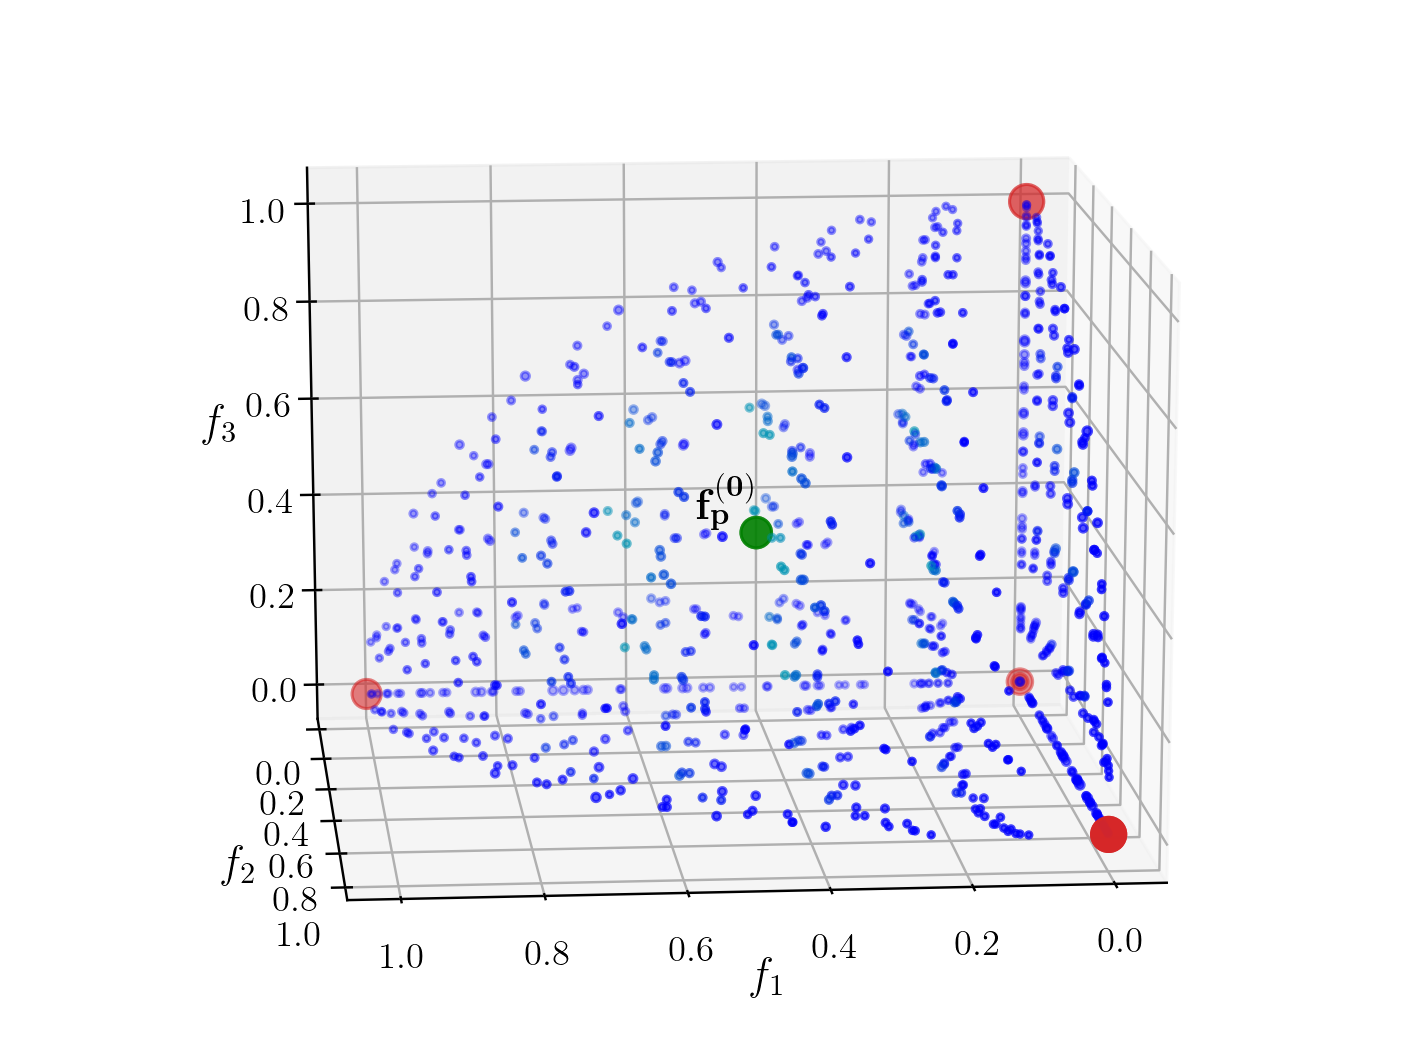

In [10]:
%matplotlib notebook
import matplotlib.colors as mc
sys.path.append('../../')
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles
from vis.plotting.utils import default_color, enhance_color

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)
    
    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)

    # change the color and size according to the requirements
    C = enhance_color(C, ifp0, color='g', alpha=1.0)
    S[ifp0] = 100.0

    pdffigpath = os.path.join(path, "scatter3d-fig1.pdf")
    svgfigpath = os.path.join(path, "scatter3d-fig1.svg")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure()) 
        scatter.plot(F, ax=ax, s=S, c=C, euler=(85,15)) #camera_angles[pf][dim])
        # mark point
        ax.text(F[ifp0,0][0], F[ifp0,1][0], z=F[ifp0,2][0], s=r'$\mathbf{f_p^{{(0)}}}$', \
                ha='right', va='bottom', fontsize='large')

        # remove white space
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.savefig(svgfigpath, bbox_inches='tight', pad_inches=0, dpi=150, format='svg')
        
        # show
        plt.show()

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


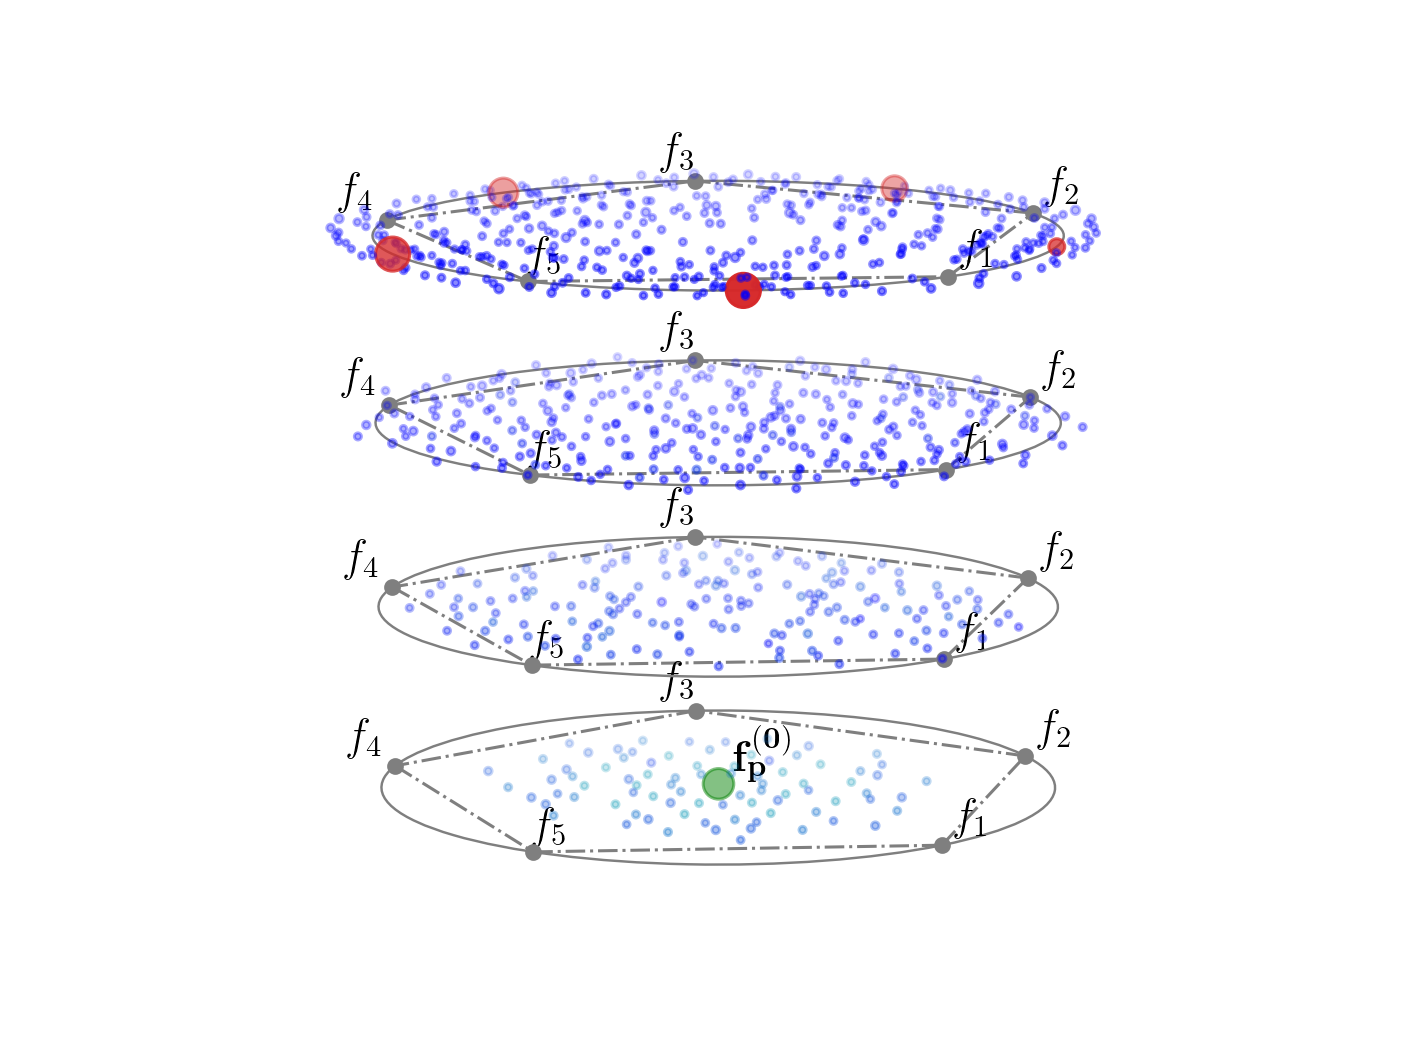

Plotting palette-star-viz.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.


In [11]:
%matplotlib notebook
import matplotlib.colors as mc
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import default_color, enhance_color

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # change the color and size according to the requirements
    C = enhance_color(C, ifp0, color='g', alpha=1.0)
    S[ifp0] = 100.0

    pdffigpath = os.path.join(path, "palette-starviz-fig1.pdf")
    svgfigpath = os.path.join(path, "palette-starviz-fig1.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure()) 
        _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, verbose=True, euler=(-40,15)) # camera_angles_star[pf][dim])
        # mark points
        ax.text(P[ifp0,0][0]+0.03, P[ifp0,1][0]+0.03, z=P[ifp0,2][0], s=r'$\mathbf{f_p^{{(0)}}}$', \
                ha='left', va='bottom', fontsize='large')
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        plt.savefig(svgfigpath, bbox_inches='tight', dpi=150, pad_inches=0, format='svg')
        
        # show
        plt.show()

### Fig 2: On the another PaletteViz with same 1000 points, plot $f^{(1)}$ and join with an arrow from $f^{(0)}$. 

Mark three equidistant intermediate points on the line:

- $p_1 = f^{(0)} + 0.25 (f^{(1)} - f^{(0)})$
- $p_2 = f^{(0)} + 0.50 (f^{(1)} - f^{(0)})$
- $p_3 = f^{(0)} + 0.75 (f^{(1)} - f^{(0)})$

Then, mark $z^{(1)}$ to $z^{(3)}$ points with another bright color. Join $z^{(1)}$ with the first intermediate point, and so on, to indicate that $z^{(1)}$ is obtained from p1 and so on. These points may be at different levels (if not, let me know, I need to add more points). Here, focus on near all these points.

In [12]:
from scipy.spatial import cKDTree

# build a tree
tree = cKDTree(F)

z = [[0.2109,0.4234,0.4271,0.6429,0.4250], \
     [0.1740,0.0000,0.3478,0.8541,0.3455], \
     [0.1589,0.1575,0.1625,0.9483,0.1569]]

# get the intermediate point indices
_,zi = tree.query(z, k=1)
zi = np.array([ifp0[0], zi[0], zi[1], zi[2], if1[0]])
print(zi)

[315 766 313 416 407]


../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


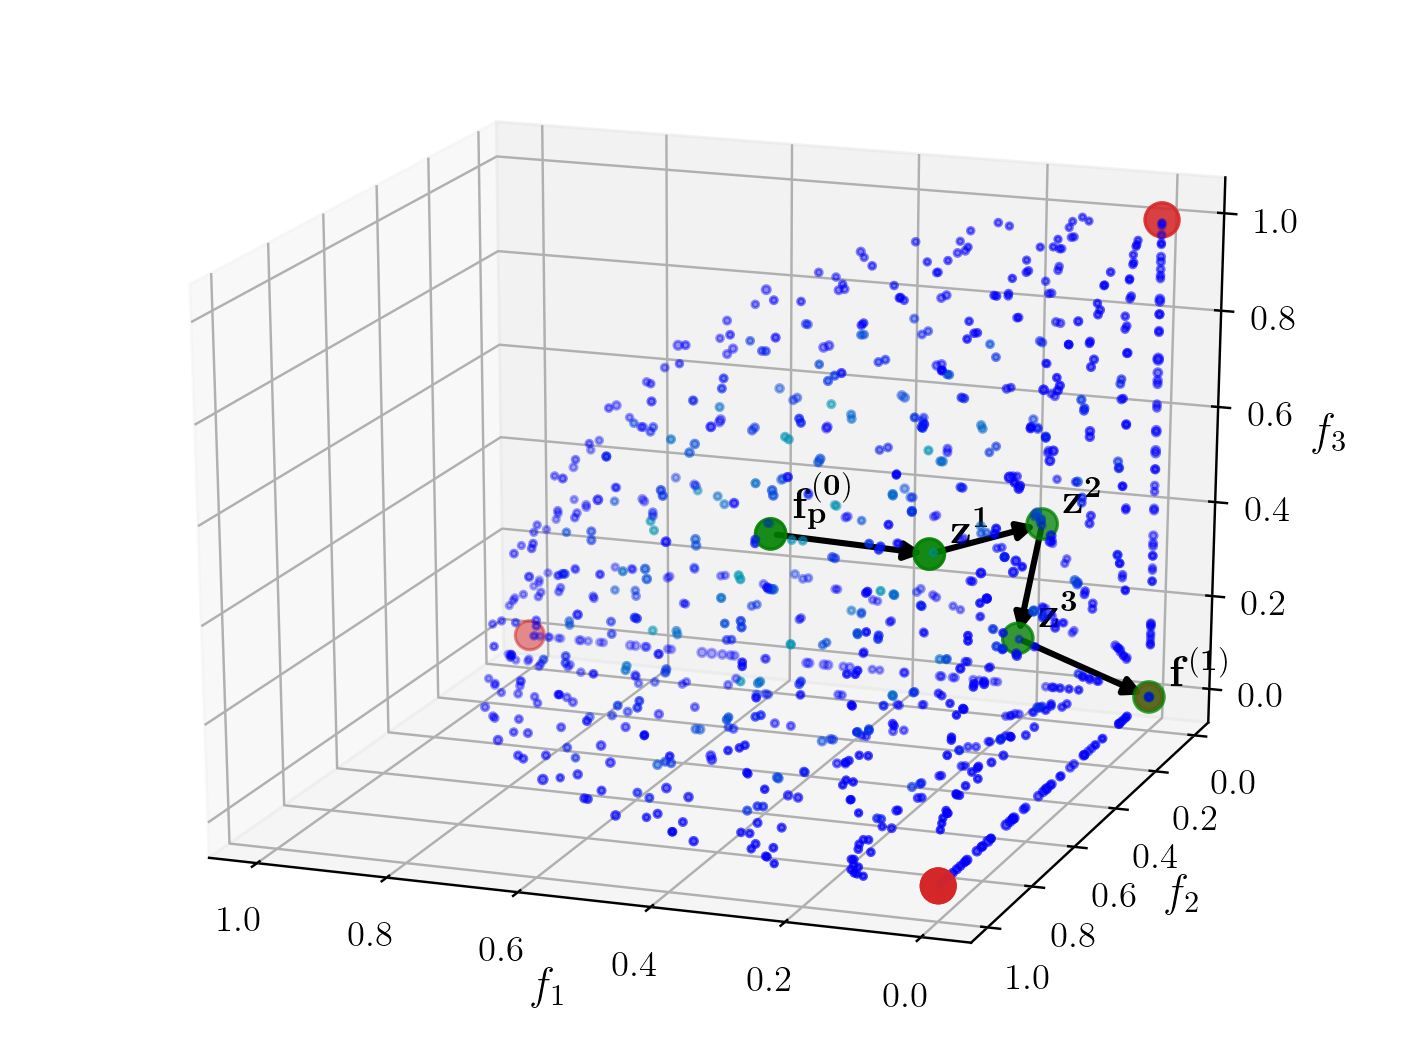

In [13]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles
from vis.plotting.utils import default_color, enhance_color, Arrow3D

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, color='g', alpha=1.0)
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(0)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{z^{{2}}}$', \
              r'$\mathbf{z^{{3}}}$', r'$\mathbf{f^{{(1)}}}$']

    pdffigpath = os.path.join(path, "scatter3d-fig2.pdf")
    svgfigpath = os.path.join(path, "scatter3d-fig2.svg")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure())
        scatter.plot(F, ax=ax, s=S, c=C, euler=(110,20))#camera_angles[pf][dim])

        # mark points
        for i in range(zi.shape[0]):
            ax.text(F[zi[i],0]-0.025, F[zi[i],1]-0.025, z=F[zi[i],2], s=labels[i], \
                    ha='left', va='bottom', fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [F[zi[i],0], F[zi[i+1],0]], \
                    [F[zi[i],1], F[zi[i+1],1]], \
                    [F[zi[i],2], F[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)

        # remove white spaces
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.savefig(svgfigpath, bbox_inches='tight', pad_inches=0, dpi=150, format='svg')
        
        # show
        plt.show()

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


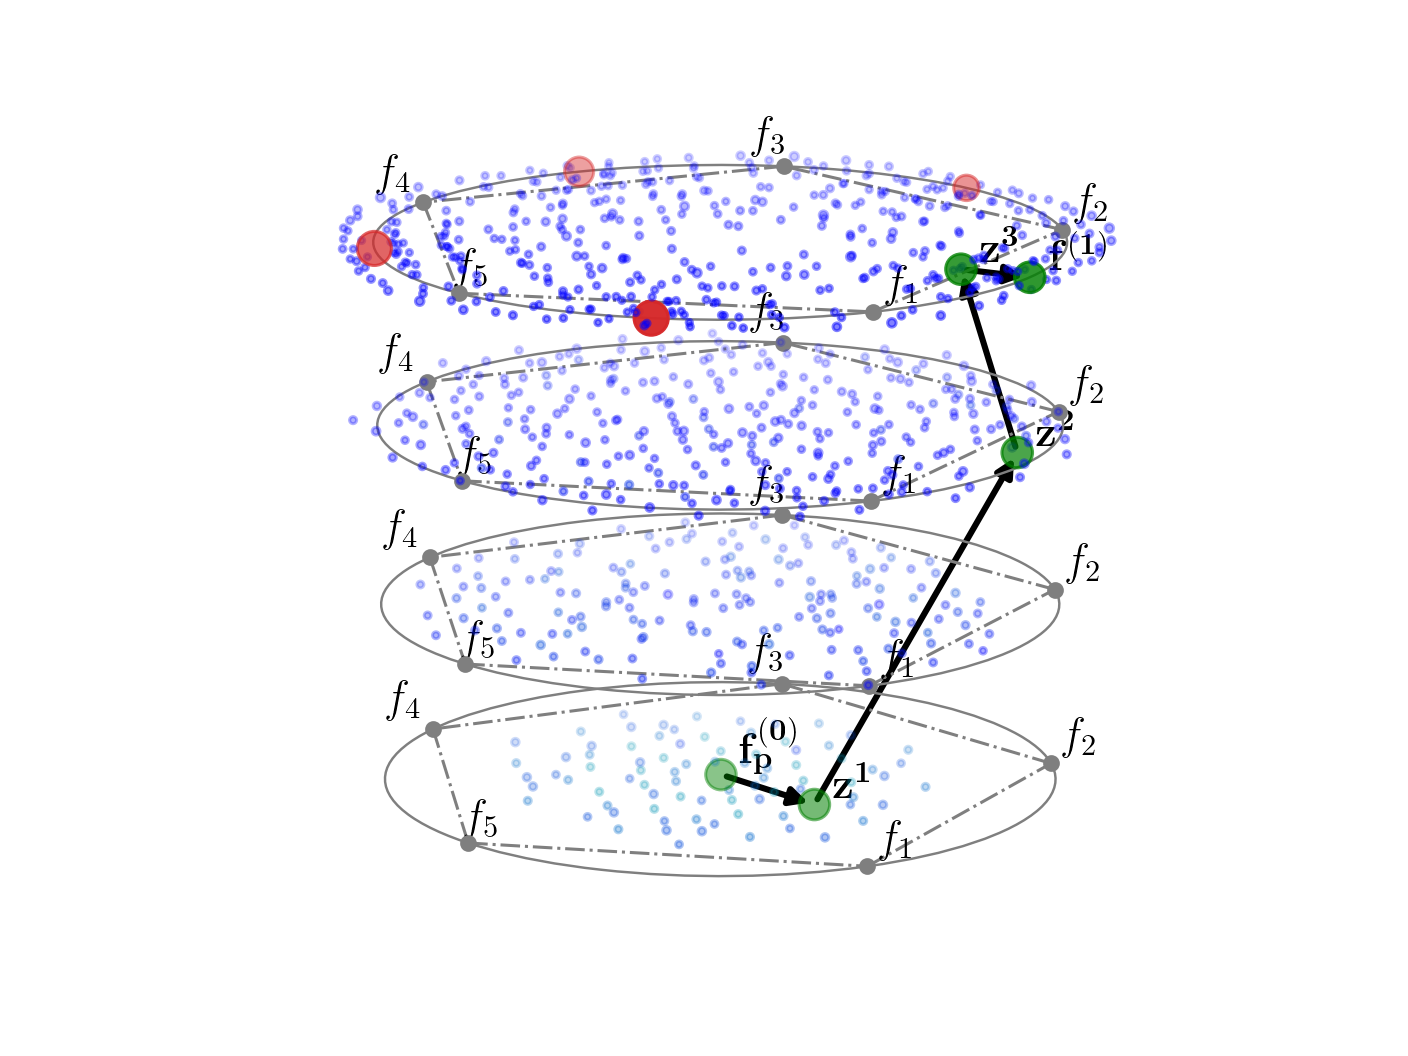

Plotting palette-star-viz.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.


In [14]:
%matplotlib notebook
import matplotlib.colors as mc
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import default_color, enhance_color

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, alpha=1.0, color='g')
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(0)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{z^{{2}}}$', \
              r'$\mathbf{z^{{3}}}$', r'$\mathbf{f^{{(1)}}}$']
    # label pos
    lpos = [['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom']]

    pdffigpath = os.path.join(path, "palette-starviz-fig2.pdf")
    svgfigpath = os.path.join(path, "palette-starviz-fig2.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        ax = Axes3D(plt.figure())
        _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, verbose=True, euler=(-25,20)) # camera_angles_star[pf][dim])
        
        # mark points
        for i in range(zi.shape[0]):
            ax.text(P[zi[i],0]+0.04, P[zi[i],1]+0.04, z=P[zi[i],2], s=labels[i], \
                    ha=lpos[i][0], va=lpos[i][1], fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [P[zi[i],0], P[zi[i+1],0]], \
                    [P[zi[i],1], P[zi[i+1],1]], \
                    [P[zi[i],2], P[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        plt.savefig(svgfigpath, bbox_inches='tight', dpi=150, pad_inches=0, format='svg')
        
        # show
        plt.show()

### Fig 3: On the another PaletteViz with same 1000 points, plot f^(2) and join with an arrow from f^(1). 

Then, mark intermediate points

 - $p_1 = f^{(1)} + 0.3333 (f^{(2)} - f^{(1)})$
 - $p_2 = f^{(1)} + 0.6667 (f^{(2)} - f^{(1)})$
 - $p_2 = f^{(1)} + 0.9999 (f^{(2)} - f^{(1)})$
 
and $z^{(1)}$ to $z^{(2)}$ points with another bright color. Join them.  Then, plot the third iteration points $f^{(3)}$, join with $f^{(2)}$, and then mark two intermediate points $p_1$ and $p_2$ and their respective points $z^{(1)}$ and $z^{(2)}$ and join. Here also focus on the points.

In [15]:
from scipy.spatial import cKDTree

# build a tree
tree = cKDTree(F)

z = [[0.0000,0.1815,0.3668,0.5412,0.7345], \
     [0.1548,0.0000,0.1527,0.3136,0.9245]]

# get the intermediate point indices
_,zi = tree.query(z, k=1)
zi = np.array([ifp1[0], zi[0], zi[1], if2[0]])
print(zi)

[766 650 111 133]


../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


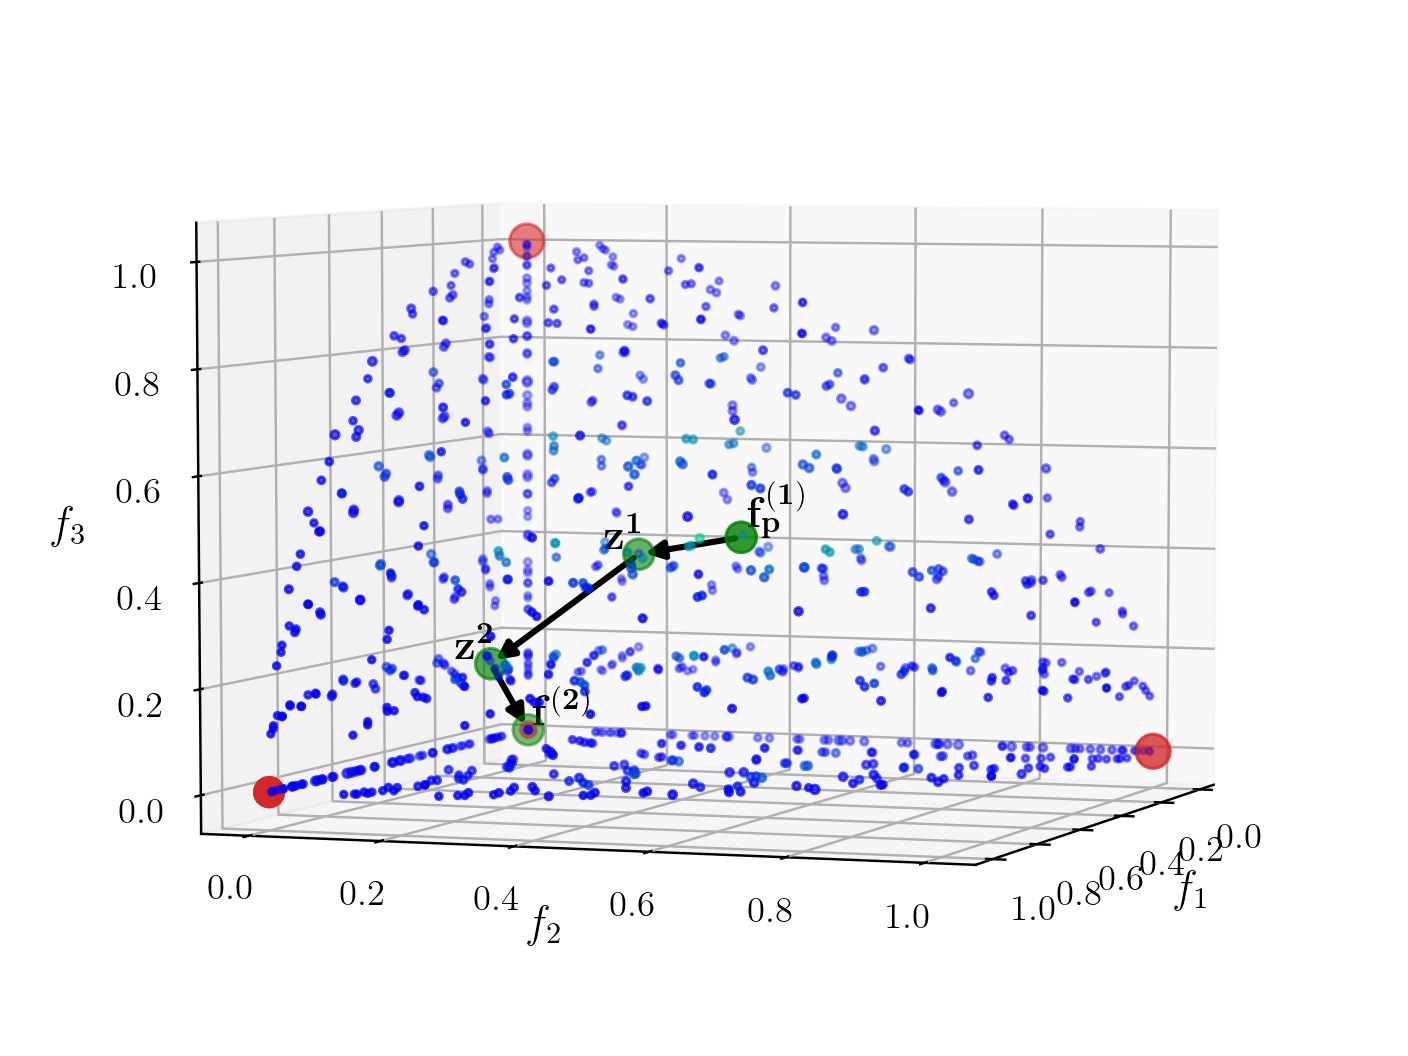

In [16]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles
from vis.plotting.utils import default_color, enhance_color, Arrow3D

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    # get the props
    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, alpha=1.0, color='g')
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(1)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{z^{{2}}}$', r'$\mathbf{f^{{(2)}}}$']
    # label pos
    lpos = [['left', 'bottom'], ['right', 'bottom'], ['right', 'bottom'], ['left', 'bottom']]

    pdffigpath = os.path.join(path, "scatter3d-fig3.pdf")
    svgfigpath = os.path.join(path, "scatter3d-fig3.svg")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure())
        scatter.plot(F, ax=ax, s=S, c=C, euler=(20,5))#camera_angles[pf][dim])
        
        # mark points
        for i in range(zi.shape[0]):
            ax.text(F[zi[i],0]+0.06, F[zi[i],1]+0.03, z=F[zi[i],2], s=labels[i], \
                    ha=lpos[i][0], va=lpos[i][1], fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [F[zi[i],0], F[zi[i+1],0]], \
                    [F[zi[i],1], F[zi[i+1],1]], \
                    [F[zi[i],2], F[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)
            
        # remove white space
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.savefig(svgfigpath, bbox_inches='tight', pad_inches=0, dpi=150, format='svg')
        
        # show
        plt.show()

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


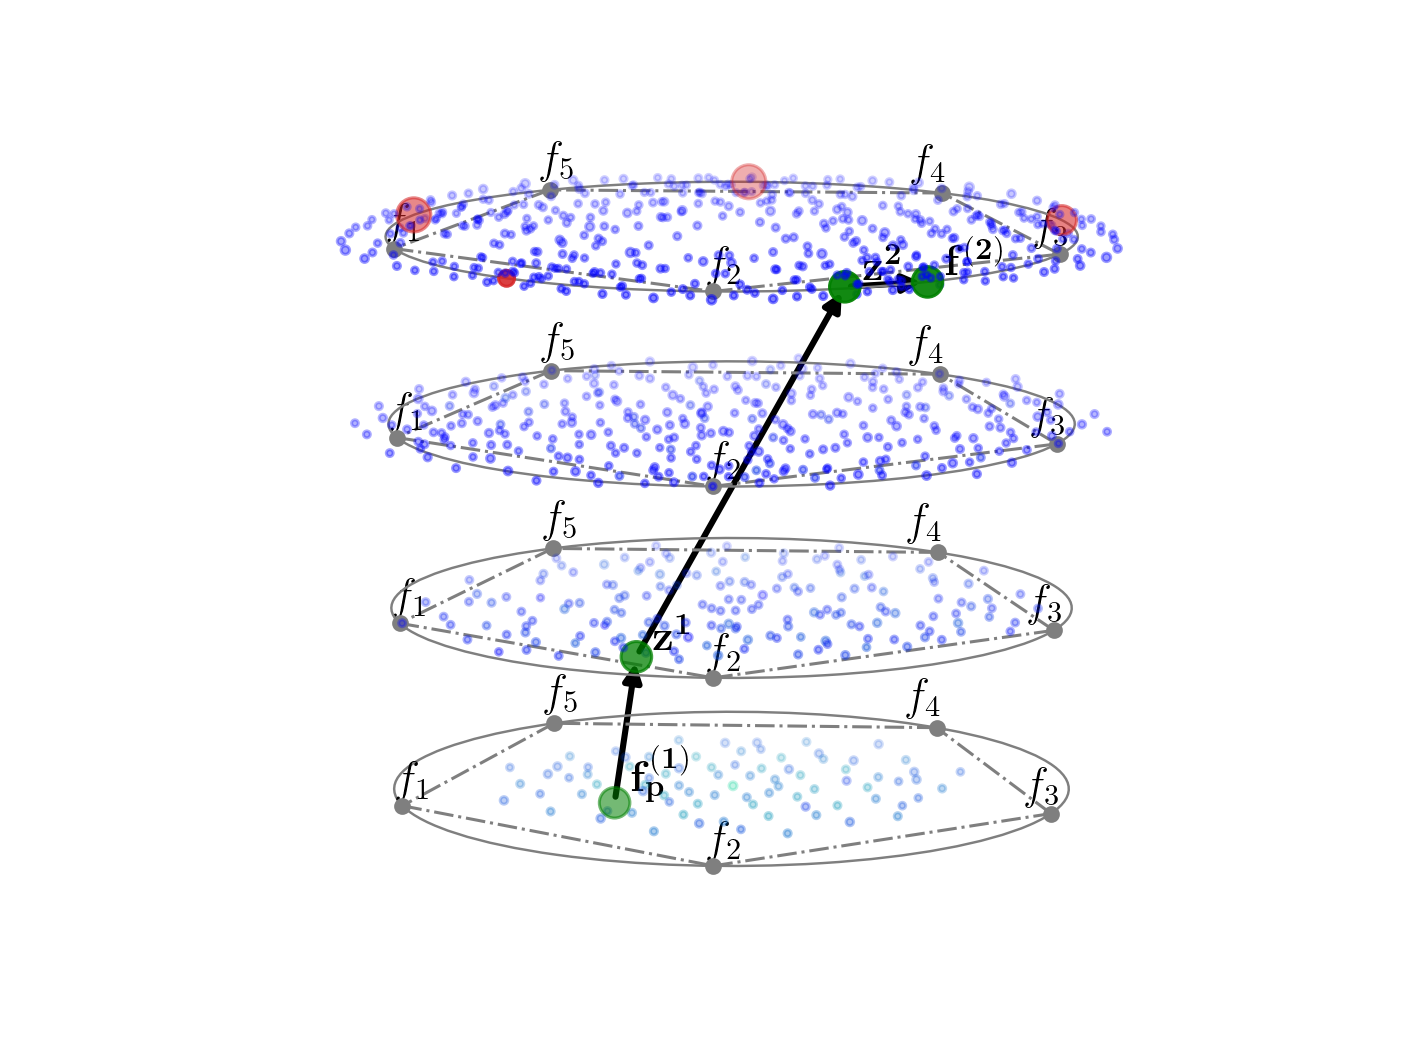

Plotting palette-star-viz.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.


In [17]:
%matplotlib notebook
import matplotlib.colors as mc
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import default_color, enhance_color

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    # get the props
    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, alpha=1.0, color='g')
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(1)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{z^{{2}}}$', r'$\mathbf{f^{{(2)}}}$']
    # label pos
    lpos = [['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom']]

    pdffigpath = os.path.join(path, "palette-starviz-fig3.pdf")
    svgfigpath = os.path.join(path, "palette-starviz-fig3.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure())
        _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, verbose=True, euler=(75,15)) # camera_angles_star[pf][dim])
        
        # mark points
        for i in range(zi.shape[0]):
            ax.text(P[zi[i],0]-0.04, P[zi[i],1]+0.04, z=P[zi[i],2], s=labels[i], \
                    ha=lpos[i][0], va=lpos[i][1], fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [P[zi[i],0], P[zi[i+1],0]], \
                    [P[zi[i],1], P[zi[i+1],1]], \
                    [P[zi[i],2], P[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        plt.savefig(svgfigpath, bbox_inches='tight', dpi=150, pad_inches=0, format='svg')
        
        # show
        plt.show()

### Fig4: Start from f_p^2, then z^1 and z^2 and then end with f^3. 

See the paper.

In [19]:
from scipy.spatial import cKDTree

# build a tree
tree = cKDTree(F)

z = [[0.0000,0.0000,0.3227,0.4845,0.8131], \
     [0.0000,0.1696,0.3456,0.3368,0.8594]]

# get the intermediate point indices
_,zi = tree.query(z, k=1)
zi = np.array([ifp2[0], zi[0], if3[0]])
print(zi)

[650 280 205]


../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


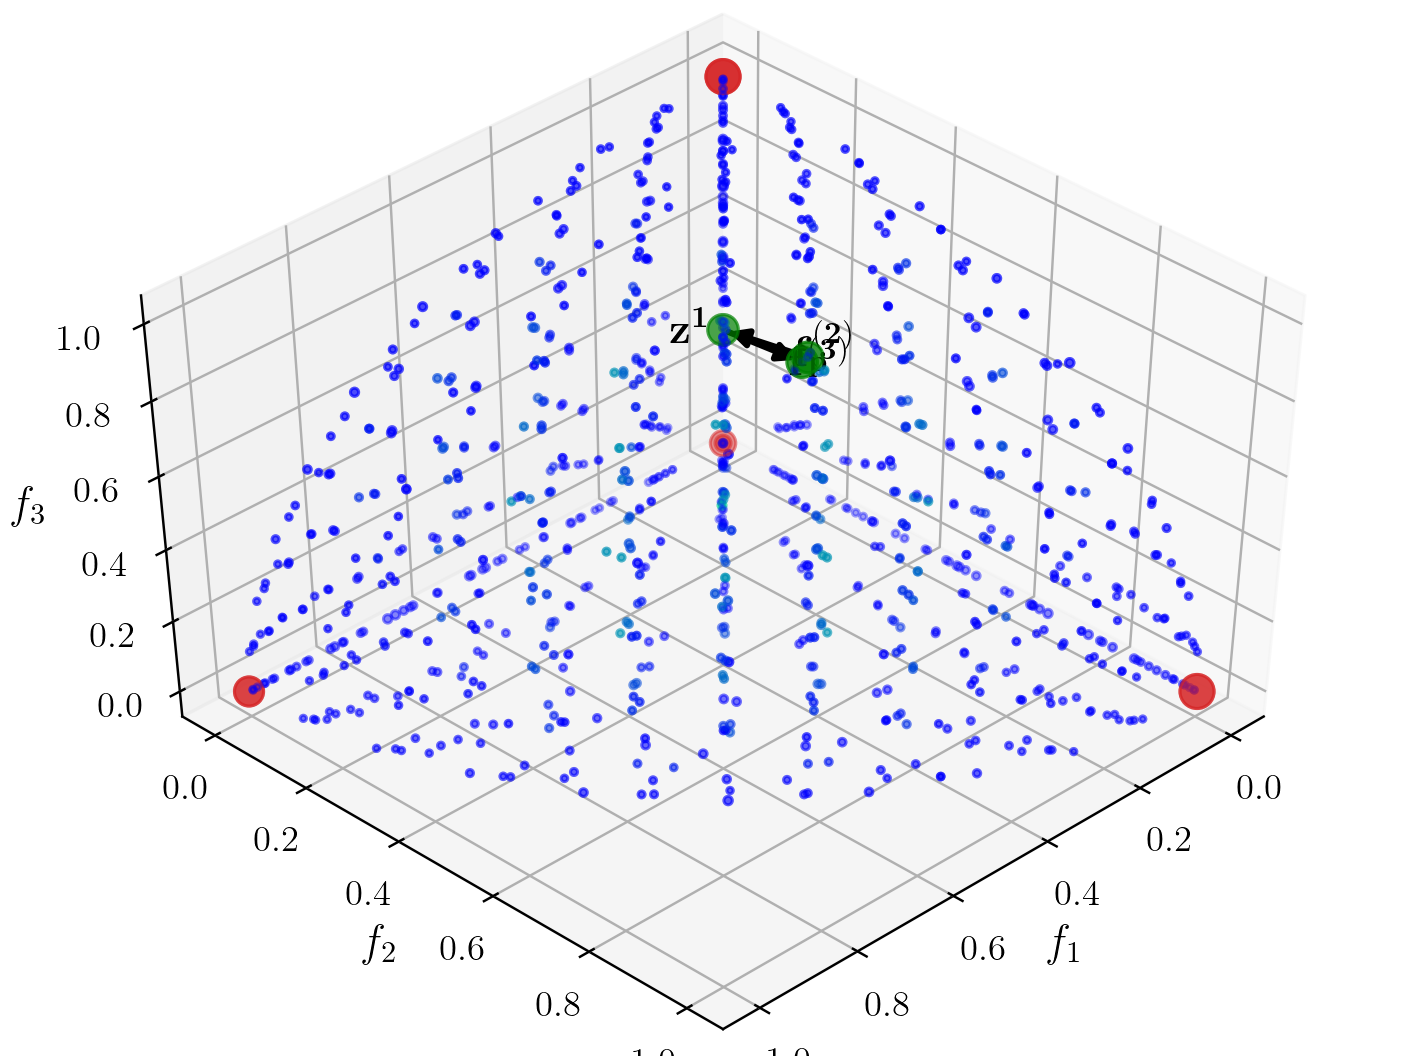

In [20]:
%matplotlib notebook
sys.path.append('../../')
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles
from vis.plotting.utils import default_color, enhance_color, Arrow3D

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    # get the props
    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, alpha=1.0, color='g')
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(2)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{f^{{(3)}}}$']
    # label pos
    lpos = [['left', 'bottom'], ['right', 'bottom'], ['left', 'bottom']]

    pdffigpath = os.path.join(path, "scatter3d-fig4.pdf")
    svgfigpath = os.path.join(path, "scatter3d-fig4.svg")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure())
        scatter.plot(F, ax=ax, s=S, c=C, euler=(45,45))#camera_angles[pf][dim])
        
        # mark points
        for i in range(zi.shape[0]):
            ax.text(F[zi[i],0]+0.06, F[zi[i],1]+0.03, z=F[zi[i],2], s=labels[i], \
                    ha=lpos[i][0], va=lpos[i][1], fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [F[zi[i],0], F[zi[i+1],0]], \
                    [F[zi[i],1], F[zi[i+1],1]], \
                    [F[zi[i],2], F[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)
            
        # remove white space
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0,0,0)
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', pad_inches=0, dpi=150)
        plt.savefig(svgfigpath, bbox_inches='tight', pad_inches=0, dpi=150, format='svg')
        
        # show
        plt.show()

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


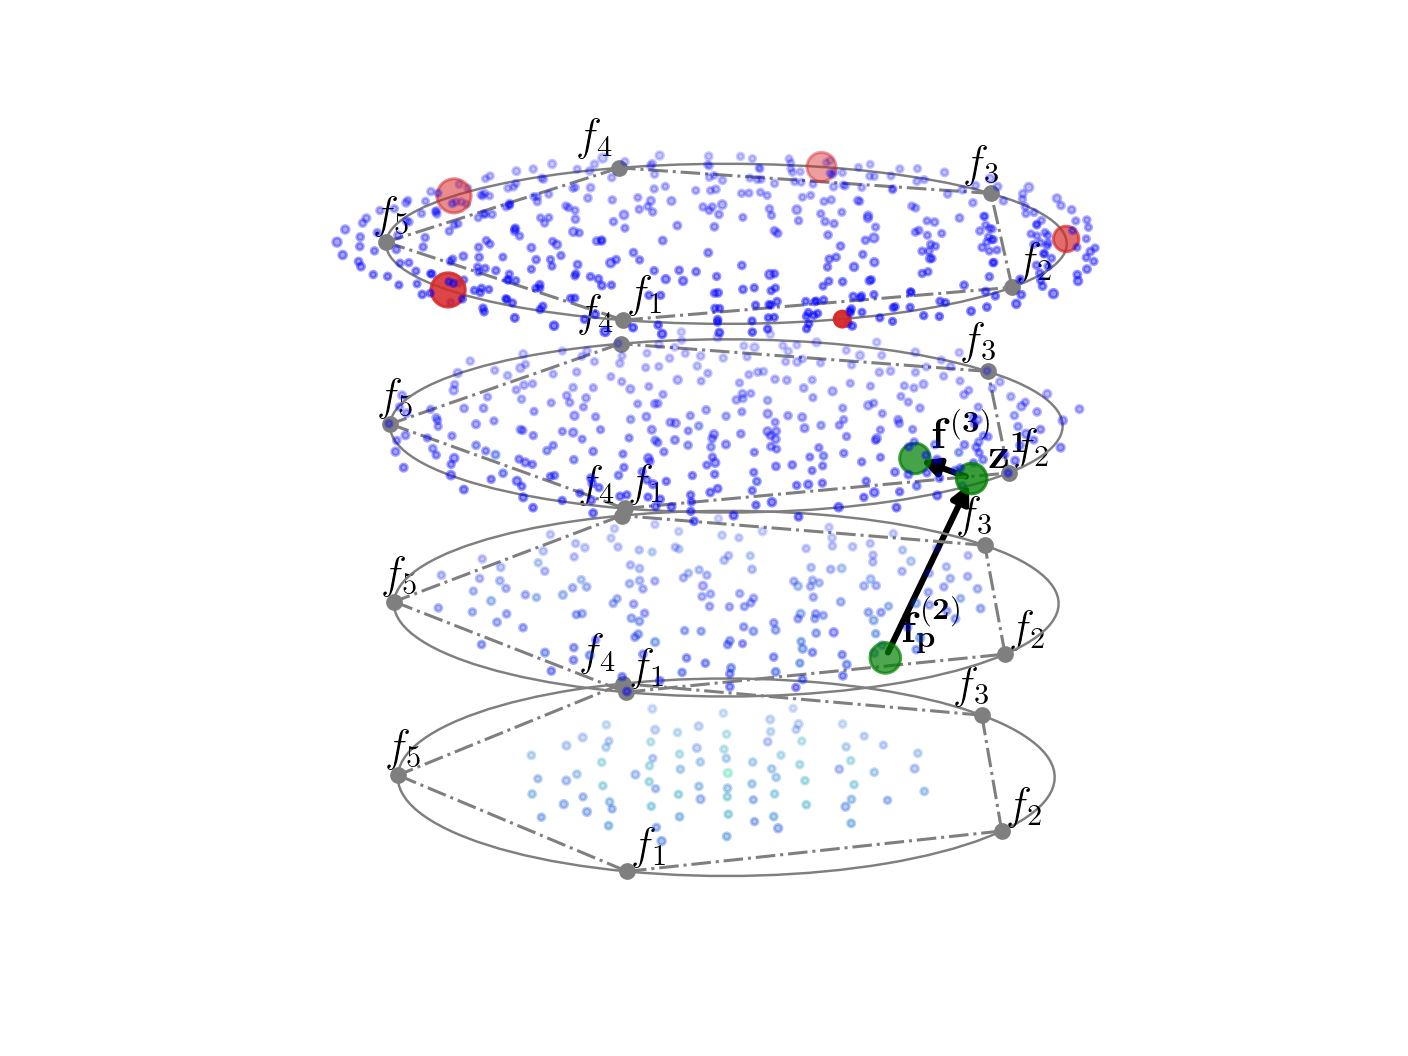

Plotting palette-star-viz.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.


In [30]:
%matplotlib notebook
import matplotlib.colors as mc
sys.path.append('../../')
from vis.plotting import paletteviz
from vis.plotting.paletteviz import camera_angles_star
from vis.plotting.utils import default_color, enhance_color

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    # load the front
    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    # get the props
    CV, Mu, Ik = load_props(path)
    S,C = decide_size_color(CV, Mu, Ik)
    
    # enhance intermediate points
    C = enhance_color(C, zi, alpha=1.0, color='g')
    S[zi] = 100.0
    # point labels
    labels = [r'$\mathbf{f_p^{{(2)}}}$', r'$\mathbf{z^{{1}}}$', r'$\mathbf{f^{{(3)}}}$']
    # label pos
    lpos = [['left', 'bottom'], ['left', 'bottom'], ['left', 'bottom']]

    pdffigpath = os.path.join(path, "palette-starviz-fig4.pdf")
    svgfigpath = os.path.join(path, "palette-starviz-fig4.svg")
    depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
    with plt.rc_context({"text.usetex": True, "font.size": 12}):
        # plot
        ax = Axes3D(plt.figure())
        _,P = paletteviz.plot(F, ax=ax, depth_contours=depth_contour_path, mode='star', \
                        n_partitions=4, s=S, c=C, verbose=True, euler=(20,20)) # camera_angles_star[pf][dim])
        
        # mark points
        for i in range(zi.shape[0]):
            ax.text(P[zi[i],0]-0.04, P[zi[i],1]+0.04, z=P[zi[i],2], s=labels[i], \
                    ha=lpos[i][0], va=lpos[i][1], fontsize='large')
        
        # draw arrows
        for i in range(zi.shape[0]-1):
            a = Arrow3D(\
                    [P[zi[i],0], P[zi[i+1],0]], \
                    [P[zi[i],1], P[zi[i+1],1]], \
                    [P[zi[i],2], P[zi[i+1],2]], \
                    mutation_scale = 12, lw = 2.0, \
                    arrowstyle = "-|>", color = 'black')
            ax.add_artist(a)
        
        # try to remove white space as much as possible
        plt.subplots_adjust(top=0.01, bottom=0, right=0.01, left=0, hspace=0, wspace=0)
        plt.margins(0.01,0.01,0.0)
        # plt.gca().xaxis.set_major_locator(plt.NullLocator())
        # plt.gca().yaxis.set_major_locator(plt.NullLocator())
        # plt.gca().zaxis.set_major_locator(plt.NullLocator())
        
        # save the fig
        plt.savefig(pdffigpath, bbox_inches='tight', dpi=150, pad_inches=0)
        plt.savefig(svgfigpath, bbox_inches='tight', dpi=150, pad_inches=0, format='svg')
        
        # show
        plt.show()